# Classification. Linear models and KNN

In [177]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [321]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel

from tabulate import tabulate
from sklearn.metrics import  mean_absolute_error, mean_squared_error, accuracy_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, plot_roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from boruta import BorutaPy
from imblearn.pipeline import Pipeline

In [179]:
# fucntion to build correlation matrix
def correlation_matrix_plot(data_for_print):
    f, ax = plt.subplots(figsize=(15, 15))
    corr = data_for_print.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [180]:
#function to remove highly correlated vars
def remove_highly_correlated_vars(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = abs(dataset.corr())
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [181]:
def replace_null_rand_gaus(df,column):
    mean = df[column].mean()
    std = df[column].std()
    is_null = df[column].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.normal(loc =mean, scale =std, size = is_null)
    age_slice = df[column].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    df[column] = age_slice.astype(int)

In [182]:
def logistic_regression(x_train, y_train, x_test):
    lr = LogisticRegression(solver='liblinear', penalty='l1', random_state=1863)
    fit_lr = lr.fit(x_train,y_train)
    print("Classificator labels: {0} \n Intersept Coef: {1} \n Coeff of model: {2}".format(lr.classes_,
                                                                                      lr.intercept_,
                                                                                     lr.coef_))
    return lr, lr.predict(x_test)

In [183]:
def model_estimators(x_test, y_test, pred, regressor):
    print(" Precision score: {0} \n Recall score: {1}".format(\
    round(precision_score(y_test,pred, average = 'weighted'),4),
round(recall_score(y_test,pred, average = 'weighted'),4)))
    
    print("\n Plot confusion matrix: ")
    plot_confusion_matrix(regressor, x_test, y_test)  
    

In [184]:
def min_max_scaler(data = None, index = None, columns = None):
    return pd.DataFrame(MinMaxScaler().fit(data).transform(data),index=index, columns=columns)

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [185]:
PATH = "./data/"

In [186]:
gender_sub = pd.read_csv(os.path.join(PATH, 'titanic', 'gender_submission.csv')).set_index('PassengerId')

In [187]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [189]:
print(data['Parch'].unique(), data['SibSp'].unique())

[0 1 2 5 3 4 6] [1 0 3 4 2 5 8]


In [190]:
data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [191]:
data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [192]:
#891 rows
#Age - null values
# pclass - (1 2 3)
# Cabin - 204 from 891 null
# Embarked - name of port (3 values: C Q S) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [193]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [195]:
print(" Number of passengers: \n Male: {0} \n Female: {1} \n".format(len(data[data['Sex'] == 'male']),
                                                             len(data[data['Sex'] == 'female'])   ))

print(" Survived passegers: \n Male: {0} \n Female: {1} \n Ratio: {2}".format(
    sum(data [ data['Sex'] == 'male']['Survived'] == 1 ),
sum(data [ data['Sex'] == 'female']['Survived'] == 1 ),
    round((sum(data [ data['Sex'] == 'female']['Survived'] == 1 )/sum(data [ data['Sex'] == 'male']['Survived'] == 1 )),4)))

 Number of passengers: 
 Male: 577 
 Female: 314 

 Survived passegers: 
 Male: 109 
 Female: 233 
 Ratio: 2.1376


<b>Amount of survived females is twice as many survived males</b>. Probability of male surviving is less 12%, while the probability of female sirviving is 83% 


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

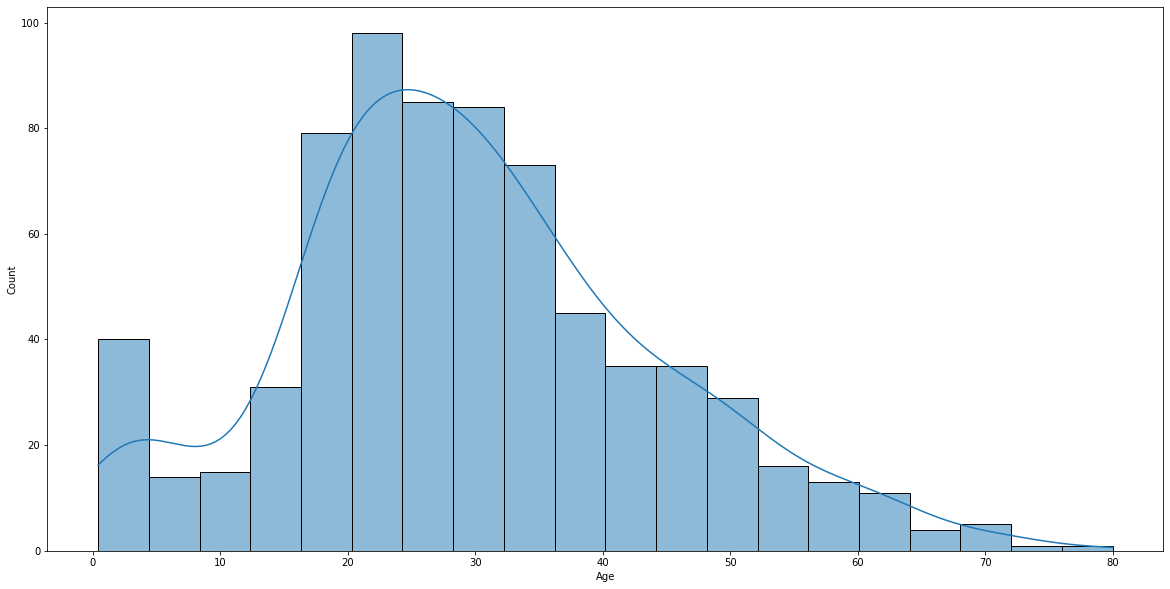

In [196]:
sns.histplot(data=data["Age"], kde=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

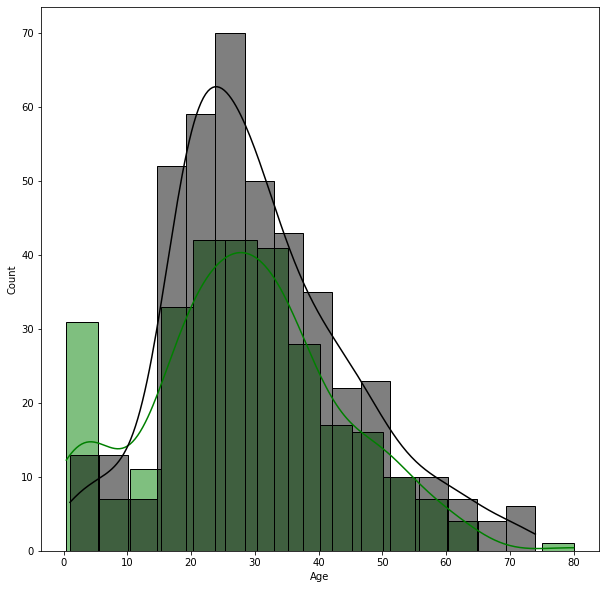

In [197]:
plt.rcParams["figure.figsize"] = (10,10)
sns.histplot(data=data[data["Survived"]==1]["Age"], kde=True, color ='green', )
sns.histplot(data=data[data["Survived"]==0]["Age"], kde=True, color ='black', )#bins = 8

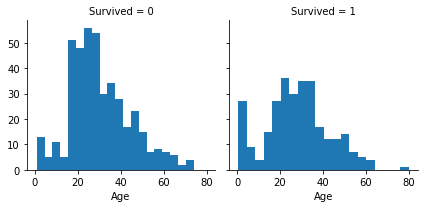

In [198]:
plt.rcParams["figure.figsize"] = (10,10)
g = sns.FacetGrid(data, col='Survived')
g.map(plt.hist, 'Age', bins=20);

In [199]:
print(data['Age'].describe(), "\nMedian   ",np.median(data['Age'].dropna()))

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 
Median    28.0


Generally, distributions look similar, besides the eldest and the youngest groups of passengers
Most of children from 0 to 5 years survived and all passengers from 65 to 75 deceased. 


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

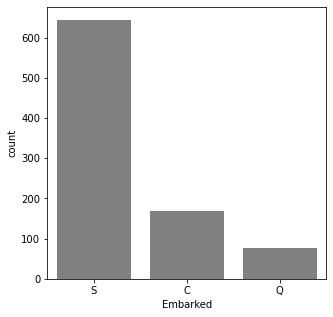

In [200]:
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(data['Embarked'], color='gray')


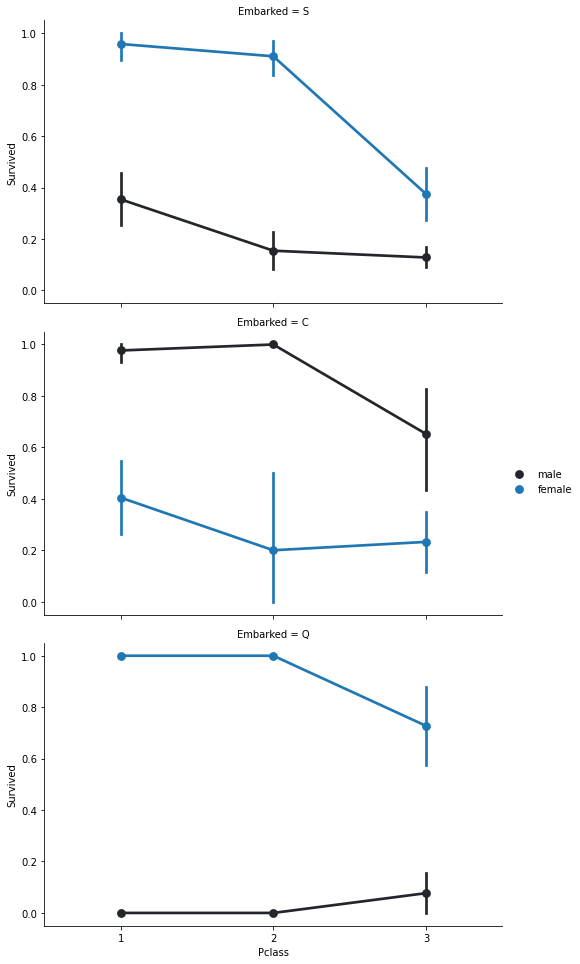

In [201]:
FacetGrid = sns.FacetGrid(data, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

([<matplotlib.axis.XTick at 0x7fe78fd78b20>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

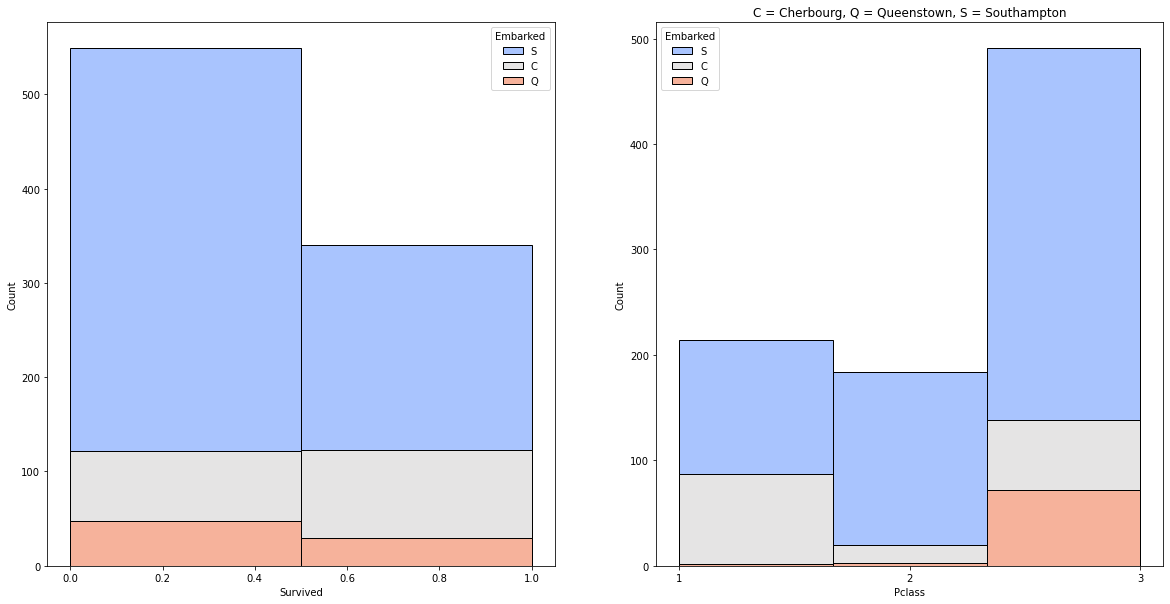

In [202]:
plt.rcParams["figure.figsize"] = (20,10)
f, axes = plt.subplots(1, 2)
plt.title('C = Cherbourg, Q = Queenstown, S = Southampton')

sns.histplot(data=data,x="Survived",hue ='Embarked', bins =2, palette ='coolwarm',multiple="stack", ax=axes[0])
plt.xticks([0,1])

sns.histplot(data=data,x="Pclass",hue ='Embarked', bins =3, palette ='coolwarm',multiple="stack", ax=axes[1])
plt.xticks([1,2,3])

Most of the passengeres were from Southampton port. The clue of high death rate is that they'd bought 3rd class tickets. Amount of survived from Cherbourg port almost the same with deceased, because a lot of passengers had had 1st class tickets. Queenstown's passengers were in the 3rd class, thus the amount of death is exceed the number of survivors. 

([<matplotlib.axis.XTick at 0x7fe78fe083d0>,
 [Text(-0.2, 0, '−0.2'), Text(0.0, 0, '0.0')])

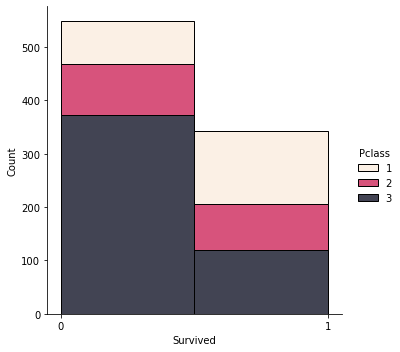

In [203]:
sns.displot(data=data,x="Survived",hue = "Pclass", bins =2, palette=  "rocket_r",multiple="stack")
plt.xticks([0,1])

In [204]:
print(data.groupby('Pclass').count())

        Survived  Name  Sex  Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked
Pclass                                                                       
1            216   216  216  186    216    216     216   216    176       214
2            184   184  184  173    184    184     184   184     16       184
3            491   491  491  355    491    491     491   491     12       491


In [205]:
print (data [['Pclass','Survived']].groupby('Pclass').mean())

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


In [206]:
print(data [['Sex', 'Pclass','Survived']].\
                       groupby(['Pclass', 'Sex']).mean())

               Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447


In [207]:
data[['Embarked','Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


First class cabin has the highest rate of surviving. Almost all woman survived at 1 and 2 class. Create new features which comprise Sex-class relation.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [208]:
top = 13
print(tabulate(
    sorted(list(zip(data.columns, data.isnull().sum(), data.isnull().sum() / data.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name      null_cnt    null_perc
----------  ----------  -----------
Cabin              687    77.1044
Age                177    19.8653
Embarked             2     0.224467
Survived             0     0
Pclass               0     0
Name                 0     0
Sex                  0     0
SibSp                0     0
Parch                0     0
Ticket               0     0
Fare                 0     0


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Age fill with Normal distributed values, because the distribution of this feature is close to normal,
Cabin drop,
Emrarked fill with mode**

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [209]:
y = data['Survived']
df = data
df = df.drop(columns=['Survived'])

In [210]:
combine = [df,test_data]

In [211]:
df =  pd.concat(combine )

### add feature Class-Sex relation

In [213]:
df['PclassSex'] = df['Pclass'].astype(str) + df['Sex'] 

### add Amount of passengers in one ticket, Fare per Person, Size of the family

In [214]:
combined=df.append(test_data)
df['PeopleInTicket']=df['Ticket'].map(combined['Ticket'].value_counts())
df['FarePerPerson']=df['Fare']/df['PeopleInTicket']


df['FamilyCount']=df['Parch']+df['SibSp']+1

### Pclass- encoding: 1class - 3, 2class - 2, 3class - 1

In [215]:
df['Pclass']= df['Pclass'].map( {1: 2, 2: 1, 3: 0}).astype(int)

In [216]:
#s = pd.get_dummies(df.Pclass, prefix='Ticket_class', drop_first=True)
#df = df.join(s)


In [217]:
#df = df.drop(columns =['Pclass'] )

### Age - random generation with mean and std
#### create Age groups 

In [218]:
replace_null_rand_gaus(df,"Age")

<AxesSubplot:xlabel='Age', ylabel='Count'>

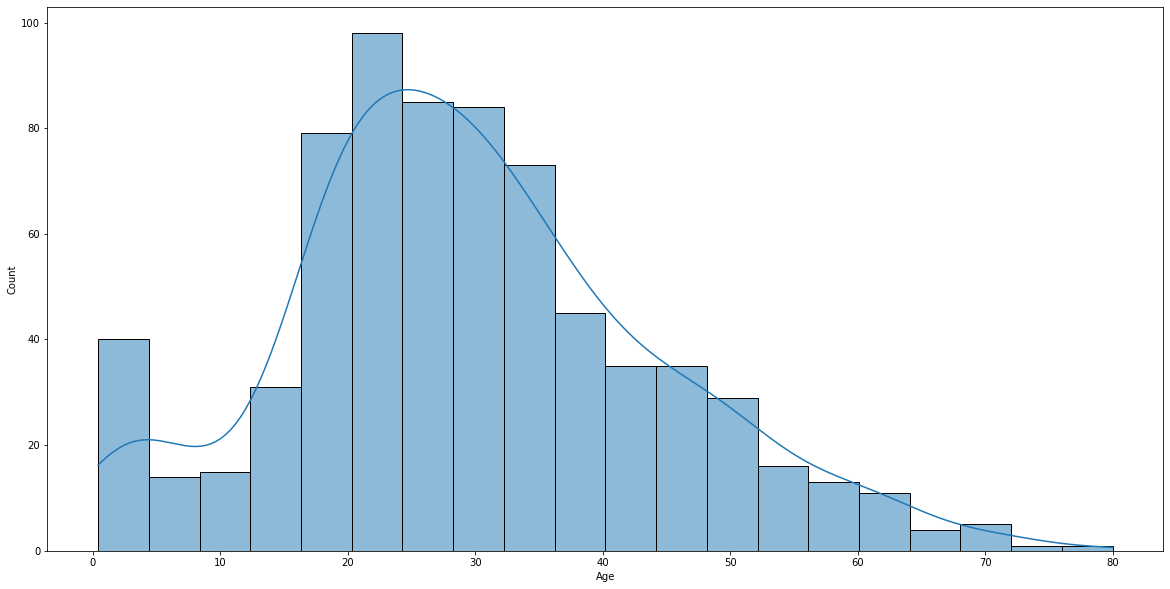

In [219]:
sns.histplot(data=data["Age"], kde=True)

group 0: 0-16 years <br>
group 1: 16-32 years <br> 
group 2: 32-48 years <br>
group 3: 48-64 years <br>
group 4:64+ years <br>

In [220]:
def create_age_groups(dataset):
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [221]:
create_age_groups(df)

In [222]:
# let's see how it's distributed 
df['Age'].value_counts()


1    631
2    345
0    184
3    133
4     16
Name: Age, dtype: int64

In [223]:
### mapping age group corresponding to the surviving rate
df['Age']= df['Age'].map( {0: 5, 1: 2, 2: 3, 3: 4, 4:1}).astype(int)

In [224]:
#s = pd.get_dummies(df.Age, prefix='Age_Group',drop_first= True)
#df = df.join(s)
#df = df.drop(columns =['Age'] )

### SibSp and Parch
combine this features to one, amount of relatives

In [225]:
df['relatives'] = df['SibSp'] + df['Parch']
df.loc[df['relatives'] > 0, 'not_alone'] = 0
df.loc[df['relatives'] == 0, 'not_alone'] = 1
df['not_alone'] = df['not_alone'].astype(int)

In [226]:
# drop sib parch famaly
'Parch', 'SibSp', 'FamilySize'
df = df.drop(['Parch', 'SibSp', 'FamilyCount'], axis=1)

### From Name extracting Title

In [227]:
# there are also crew memders such as Capt Countess etc.
# the most common leave and rarely encountering replace with one group
# I had the idea to combine crew staff but most of them has 'Mr' title
# So replece not common with one group and Mlle -> Miss etc

In [228]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
### Miss Mr Mrs 
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [229]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [230]:
data['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [231]:
#mrs- 5 miss -4 master - 3 rare - 2 mr - 1

In [232]:
dict_title = {"Mr": 0, "Miss": 3, "Mrs": 4, "Master": 2, "Rare": 1}

In [233]:
df['Title'] = df['Title'].map(dict_title)


### Sex -encoding

In [234]:
s = pd.get_dummies(df.Sex, prefix='Sex', drop_first=True)
df = df.join(s)
df = df.drop(columns =['Sex'] )

### Embarked - encoding related to persent of survivals

In [235]:
#mode
mode_embarked = df.Embarked.dropna().mode()[0]
mode_embarked

'S'

In [236]:
df['Embarked'] = df['Embarked'].fillna('S')

In [237]:
df['Embarked']= df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [238]:
#s = pd.get_dummies(df.Embarked, prefix='Port_embarked')
#df = df.join(s)
#df = df.drop(columns =['Embarked'] )

### encode PclassSex

In [240]:
df.PclassSex.unique()

array(['3male', '1female', '3female', '1male', '2female', '2male'],
      dtype=object)

In [241]:
dict_class_sex = {'3male':1-1, '1female':6-1, '3female':4-1, '1male':3-1, '2female':5-1, '2male':2-1}

In [242]:
df['PclassSex'] = df['PclassSex'].map(dict_class_sex)

In [243]:
#s = pd.get_dummies(df.PclassSex, prefix='Sex_class', drop_first=True)
#df = df.join(s)
#df = df.drop(columns =['PclassSex'] )

### Create age*class

In [245]:
df['Age*Class'] = df.Age * df.Pclass

### Fare, 1 missing value. Fare drop, fareperperson encode, split fare per person for 3 groups according to cabin class

In [246]:
df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
df['FarePerPerson'].fillna(df['FarePerPerson'].dropna().median(), inplace=True)

In [247]:
df =  df.drop(['Fare'],axis = 1)

In [248]:
data['FarePerPerson'] = pd.qcut(data['Fare'], 3)
data[['FarePerPerson', 'Survived']].groupby(['FarePerPerson'], as_index=False).mean().sort_values(by='FarePerPerson', ascending=True)

,FarePerPerson,Survived
0,"(-0.001, 8.662]",0.198052
1,"(8.662, 26.0]",0.402778
2,"(26.0, 512.329]",0.559322


In [249]:
df.loc[df['FarePerPerson'] <= 8.662, 'FarePerPerson'] = 1
df.loc[(df['FarePerPerson'] > 8.662) & (df['FarePerPerson'] <= 26), 'FarePerPerson'] = 2
df.loc[(df['FarePerPerson'] > 26) & (df['FarePerPerson'] <= 512), 'FarePerPerson'] = 3
df['FarePerPerson'] = df['FarePerPerson'].astype(int)

In [251]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [252]:
df["Cabin"] = df["Cabin"].str[:1]
data["Cabin"] = data["Cabin"].str[:1]

In [253]:
df.Cabin.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [254]:
data[['Cabin','Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
3,D,0.757576
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.593220
6,G,0.500000
0,A,0.466667
7,T,0.000000


In [255]:
df.Cabin.value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64

In [256]:
print(data [['Cabin', 'Pclass','Survived']].\
                       groupby(['Pclass', 'Cabin']).mean())

              Survived
Pclass Cabin          
1      A      0.466667
       B      0.744681
       C      0.593220
       D      0.758621
       E      0.720000
       T      0.000000
2      D      0.750000
       E      0.750000
       F      0.875000
3      E      1.000000
       F      0.200000
       G      0.500000


In [257]:
print(data [['Cabin','Survived']].\
                       groupby([ 'Cabin']).mean())

       Survived
Cabin          
A      0.466667
B      0.744681
C      0.593220
D      0.757576
E      0.750000
F      0.615385
G      0.500000
T      0.000000


In [258]:
df['Age*Sex'] = df.Age * df.Sex_male

### Drop Name Ticket Cabin

In [259]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

In [260]:
df.shape

(1309, 12)

### split Test data and train, 892 row

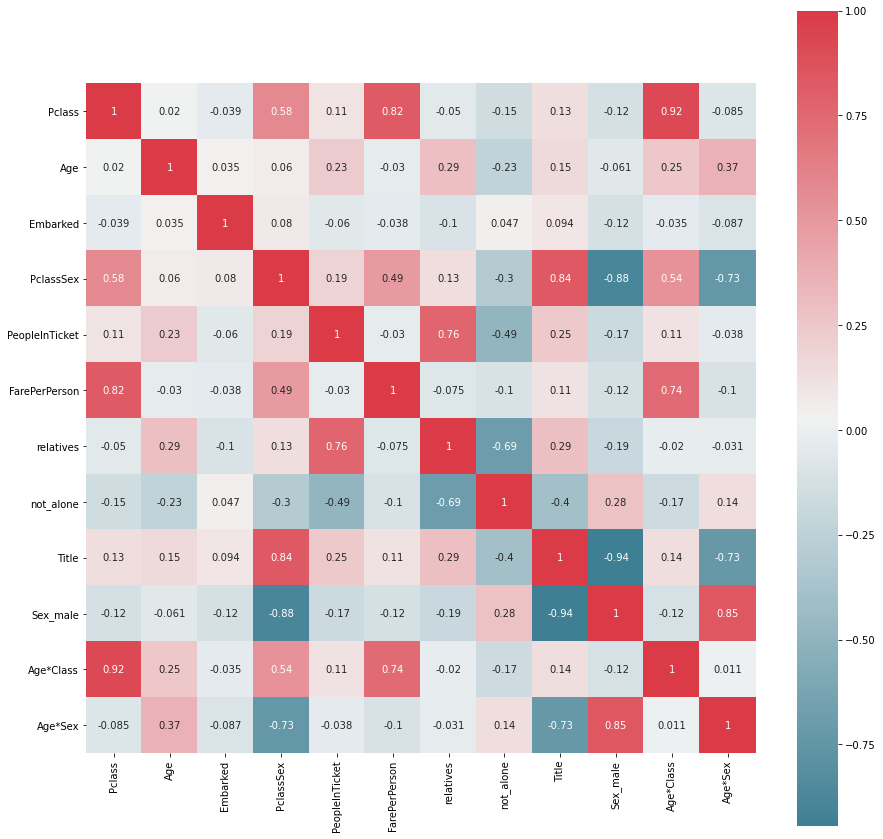

In [261]:
correlation_matrix_plot(df)

In [262]:
#remove_highly_correlated_vars(df,0.8)

In [263]:
test_data = df.iloc[891:,:]
df = df.iloc[:891,:]

### MinMax scaler

In [323]:
df = min_max_scaler(data = df, index = df.index, columns = df.columns)

### target

In [266]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [267]:
len(y)

891

### split data 

In [268]:
x_train, x_test, y_train, y_test = train_test_split(df, y,test_size=0.3, random_state=1863)

In [269]:
lr, pred  = logistic_regression(x_train, y_train, x_test)

Classificator labels: [0 1] 
 Intersept Coef: [-2.00337847] 
 Coeff of model: [[ 0.64202023  0.00416012  0.30498516  0.          0.11244538  0.00657142
  -0.487358   -0.64309799  0.84521566  0.          0.12567681  0.00495053]]


 Precision score: 0.8313 
 Recall score: 0.8321

 Plot confusion matrix: 


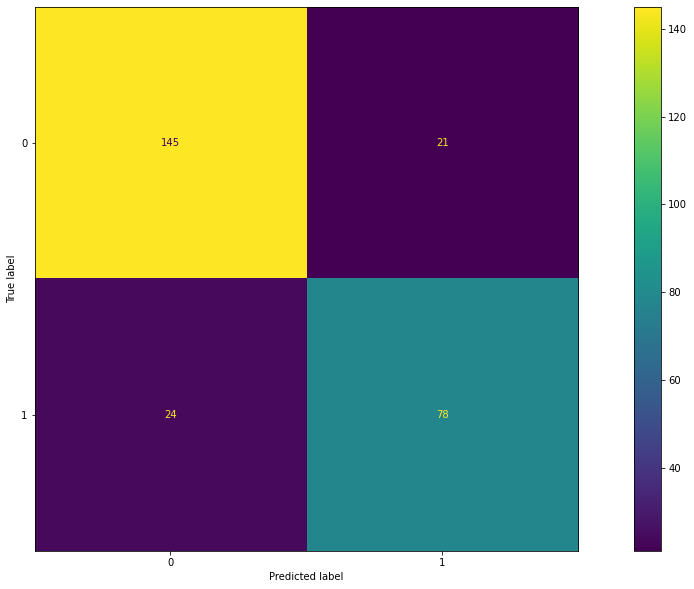

In [271]:
model_estimators(x_test, y_test, pred, lr)

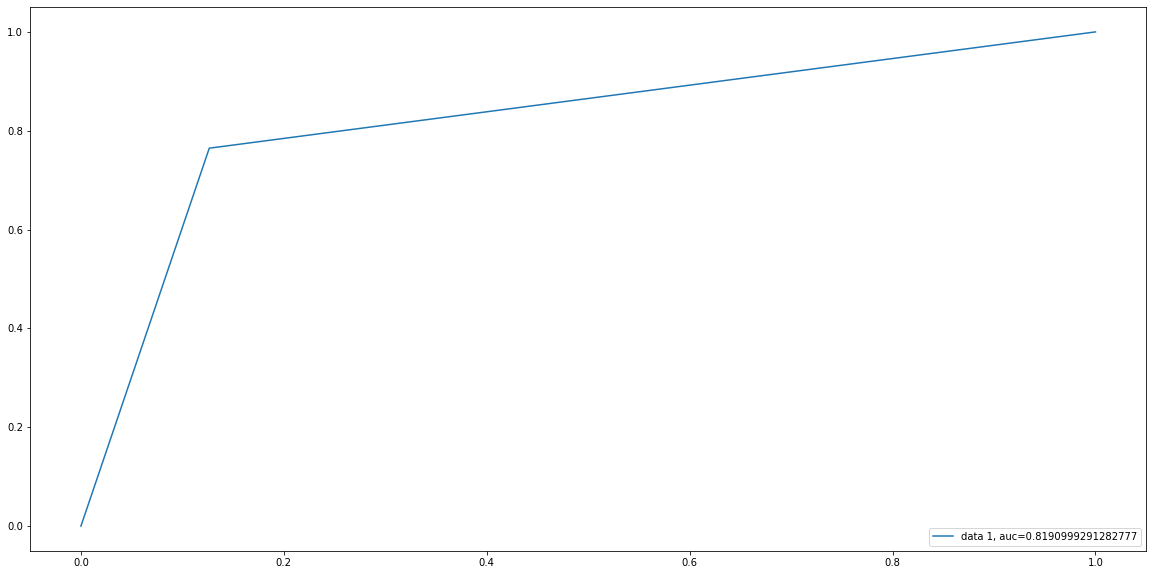

In [272]:
fpr, tpr, _ = roc_curve(y_test,  pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [122]:
#smote = SMOTE()
#df, y = smote.fit_resample(df,y)


In [123]:
x_train, x_test, y_train, y_test = train_test_split(df, y,test_size=0.3, random_state=1863)

In [124]:
lr, pred  = logistic_regression(x_train, y_train, x_test)

Classificator labels: [0 1] 
 Intersept Coef: [-2.23711814] 
 Coeff of model: [[ 1.00583249  0.10228056  0.27338528  0.84335522  0.1058388  -0.49710102
  -0.65171146  0.        ]]


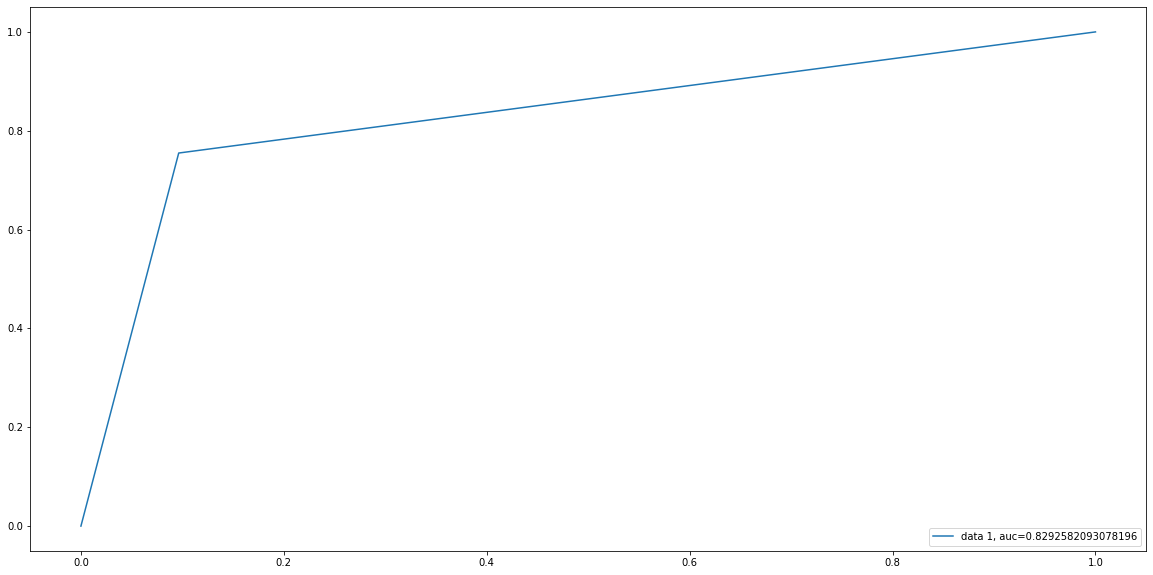

In [125]:
fpr, tpr, _ = roc_curve(y_test,  pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [303]:
lr_gender_sub = lr.predict(test_data)

In [304]:
lr.score(test_data, gender_sub)

0.9186602870813397

In [305]:
#res_titanic_df_lr = pd.DataFrame({'PassengerId':test_data.index, 'Survived': lr_gender_sub })
#res_titanic_df_lr.to_csv(path_or_buf=os.path.join(PATH, 'titanic','titanic_pred.csv'), header =True,index=False,encoding = "ISO-8859-1")

### Grid for  Logistic

In [129]:
params = {
    'penalty':['l1', 'elasticnet'],        
    'solver':['liblinear'],
    'C': np.linspace(0.5,1,20),
    'l1_ratio' : np.arange(0.001,0.1,20),
    'intercept_scaling': np.arange(0.5,1.4,0.1)
}

In [130]:
lr_a = LogisticRegression(random_state=1863, max_iter=1000,n_jobs = -1)
lr_gs = GridSearchCV(lr_a, params, cv=5, verbose=1).fit(x_train, y_train)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits


In [131]:
lr_gs.fit(x_train, y_train)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          random_state=1863),
             param_grid={'C': array([0.5       , 0.52631579, 0.55263158, 0.57894737, 0.60526316,
       0.63157895, 0.65789474, 0.68421053, 0.71052632, 0.73684211,
       0.76315789, 0.78947368, 0.81578947, 0.84210526, 0.86842105,
       0.89473684, 0.92105263, 0.94736842, 0.97368421, 1.        ]),
                         'intercept_scaling': array([0.5..., 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
                         'l1_ratio': array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096, 0.101, 0.106, 0.111, 0.116, 0.121, 0.126, 0.131,
       0.136, 0.141, 0.146, 0.151, 0.156, 0.161, 0.166, 0.171, 0.176,
       0.181, 0.186, 0.191, 0.196]),
                         'penalty': ['l1', 'elasticnet'],
                         'solver': ['liblinear

In [143]:
lr_ds_pred = lr_gs.predict(x_test)

In [132]:

print(lr_gs.best_score_)

print(lr_gs.best_params_)

print(lr_gs.best_estimator_)

0.8011096774193549
{'C': 0.6578947368421053, 'intercept_scaling': 1.1999999999999997, 'l1_ratio': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.6578947368421053, intercept_scaling=1.1999999999999997,
                   l1_ratio=0.001, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=1863, solver='liblinear')


In [133]:
'''
0.8011096774193549
{'C': 0.6578947368421053, 'intercept_scaling': 1.1999999999999997, 'l1_ratio': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.6578947368421053, intercept_scaling=1.1999999999999997,
                   l1_ratio=0.001, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=1863, solver='liblinear')
'''

"\n0.8011096774193549\n{'C': 0.6578947368421053, 'intercept_scaling': 1.1999999999999997, 'l1_ratio': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}\nLogisticRegression(C=0.6578947368421053, intercept_scaling=1.1999999999999997,\n                   l1_ratio=0.001, max_iter=1000, n_jobs=-1, penalty='l1',\n                   random_state=1863, solver='liblinear')\n"

 Precision score: 0.8386 
 Recall score: 0.8396

 Plot confusion matrix: 


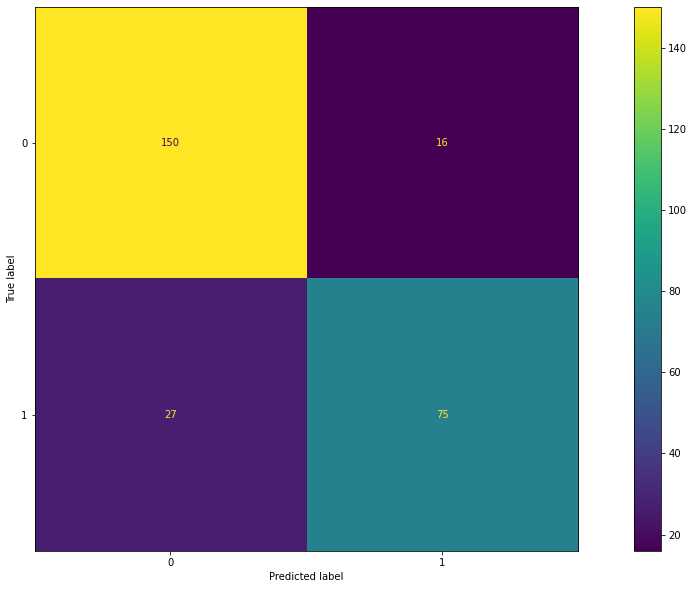

In [144]:
model_estimators(x_test, y_test, lr_ds_pred, lr_gs)

In [ ]:
#lr_gs.score(test_data, gender_sub)

In [307]:
#res_titanic_df_lr_gs = lr_gs.predict(test_data)

In [ ]:
#res_titanic_df_lr_gs

In [ ]:
#res_titanic_df_lr_gs = pd.DataFrame({'PassengerId':test_data.index, 'Survived': res_titanic_df_lr_gs})
#res_titanic_df_lr_gs.to_csv(path_or_buf=os.path.join(PATH, 'titanic','titanic_pred.csv'), header =True,index=False, encoding = "ISO-8859-1")



In [308]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)

In [309]:
#lr = round(lr.score(x_train, y_train) * 100, 2)

In [310]:
print(acc_knn)

84.91


 Precision score: 0.865 
 Recall score: 0.8619

 Plot confusion matrix: 


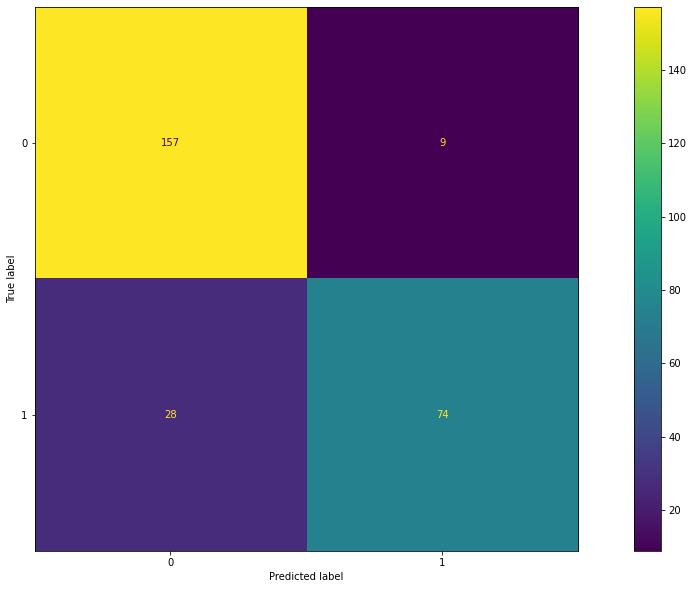

In [311]:
model_estimators(x_test, y_test, y_pred, knn)

In [314]:
#res_titanic_df_knn = knn.predict(test_data)

In [316]:
#res_titanic_df_knn = pd.DataFrame({'PassengerId':test_data.index, 'Survived': res_titanic_df_knn})
#res_titanic_df_knn.to_csv(path_or_buf=os.path.join(PATH, 'titanic','titanic_pred.csv'), header =True,index=False, encoding = "ISO-8859-1")




### Grid

In [289]:
knn = KNeighborsClassifier(n_jobs = -1)

In [290]:
k_range = list(range(5, 7))
leaf_size = list(range(20,40,1))
weight_options = ["uniform", "distance"]

In [291]:
param_grid = {
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'n_neighbors' : k_range,
    'p' : np.arange(0.7,2.2,0.3),
    'leaf_size' : leaf_size,
    'weights' : weight_options
}

In [292]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')

In [293]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
                         'n_neighbors': [5, 6],
                         'p': array([0.7, 1. , 1.3, 1.6, 1.9, 2.2]),
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [294]:

print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

0.8418820488721804
{'algorithm': 'kd_tree', 'leaf_size': 32, 'n_neighbors': 6, 'p': 1.0, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=32, n_jobs=-1,
                     n_neighbors=6, p=1.0)


In [295]:
knn_gs_pred = grid.predict(x_test)

 Precision score: 0.8636 
 Recall score: 0.8545

 Plot confusion matrix: 


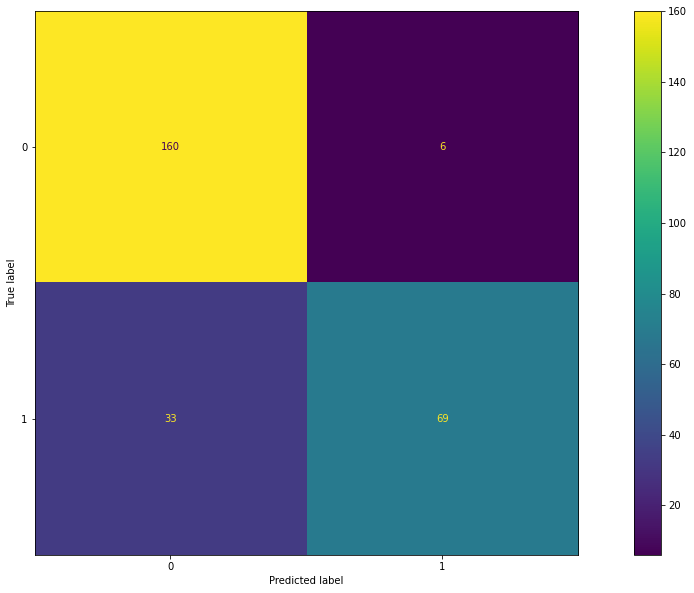

In [296]:
model_estimators(x_test, y_test, knn_gs_pred, grid)

In [302]:
'''
0.8418820488721804
{'algorithm': 'kd_tree', 'leaf_size': 32, 'n_neighbors': 6, 'p': 1.0, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=32, n_jobs=-1,
                     n_neighbors=6, p=1.0)
                     '''

"0.8418820488721804\n{'algorithm': 'kd_tree', 'leaf_size': 32, 'n_neighbors': 6, 'p': 1.0, 'weights': 'uniform'}\nKNeighborsClassifier(algorithm='kd_tree', leaf_size=32, n_jobs=-1,\n                     n_neighbors=6, p=1.0)"

In [317]:
res_titanic_df_knn_gs = grid.predict(test_data)

In [318]:
res_titanic_df_knn_gs = pd.DataFrame({'PassengerId':test_data.index, 'Survived': res_titanic_df_knn_gs})
res_titanic_df_knn_gs.to_csv(path_or_buf=os.path.join(PATH, 'titanic','titanic_pred.csv'), header =True,index=False, encoding = "ISO-8859-1")


In [319]:
res_titanic_df_knn_gs.shape

(418, 2)

In [320]:
test_data.shape

(418, 12)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

### Eventually, I selected KNN model with tunning params by grid search
The highest score is 0.78708 <br>
https://www.kaggle.com/eugeneolh <br>
https://www.kaggle.com/c/titanic/submissions <br>
Second part hasn't been finished.

## Part 2: Porto Seguro’s Safe Driver Prediction

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from time import time

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')
sample_submission = pd.read_csv(os.path.join(PATH, 'porto', 'sample_submission.csv')).set_index('id')


In [ ]:
insurance_data.head()

In [ ]:
insurance_data.shape

In [ ]:
insurance_data.describe()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, clf.predict(X_valid))
auc = roc_auc_score(y_valid, clf.predict(X_valid))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

In [ ]:
insurance_data['target'].value_counts()

In [ ]:
21694/573518

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

n— Количество объектов в выборке

n_0— Количество объектов класса «0»

n_1— Количество объектов класса «1»

TP— True Positive (верный ответ модели на истинном классе «1» при заданном пороге)

FP— False Positive (неверный ответ модели на истинном классе «0» при заданном пороге)

TPR— True Positive Rate (отношение TP к n_1)

FPR— False Positive Rate (отношение FP к n_0)

i,j— текущий индекс элемента.
$$AUC = \int_{0}^{1} TPR \,dFPR = \frac{1}{n_0 * n_1}\ \int_{0}^{1} TP \,dFP$$

$$ G =  \int_{0}^{1} TPR \,d\frac{TP+FP}{n_0 * n_1}\ -0.5 $$

$$ G_{norm} = \frac{G_{modeled}}{G_{perfect}}$$

$$ G_{norm} = \frac{\int_{0}^{1} TPR \,d\frac{TP+FP}{n_0 * n_1}\ -0.5 }{\int_{0}^{1}  \,d\frac{TP}{n_0 * n_1}\ -0.5 } $$

$$ G_{norm} =  -\int_{0}^{1}d\frac{TP^{2}+FP*TP}{n_0 * n_1}\ + \int_{0}^{1}\,d\frac{(TP+FP)*TP}{n_0 * n_1}\ $$

$$G_{norm} = \int_{0}^{1}\,d\frac{(TP+FP)*TP}{n_0 * n_1}\ +1$$
$$G_{norm} = \frac{1}{n_0 * n_1}\int_{0}^{1}\,d((TP+FP)*TP) +1 = -1 + \frac{2}{n_0 * n_1}\int_{0}^{1}TP\,dFP = 2*AUC -1$$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

For visualisation other possible metrics are Lift Curve and Cumulative gains chart. Also, Hoover index can be applied for estimation of the problem

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')
insurance_data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')
sample_submission = pd.read_csv(os.path.join(PATH, 'porto', 'sample_submission.csv')).set_index('id')

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])
labels= X.columns.tolist()

In [ ]:
X.info()

In [ ]:
print('Nan values =', X.isnull().sum().sum())

In [ ]:
cat_features = [cat for cat in labels if 'cat' in cat]
bin_features = [binl for binl in labels if 'bin' in binl]

In [ ]:
print("catergorical:", len(cat_features),'\n', 'binary:', len(bin_features))

In [ ]:
data=[]
for f in X.columns:

    if f=='target':
        role='target'
    elif f=='id':
        role='id'
    else:
        role='input'
        

    if 'bin' in f or f=='target':
        level='binary'
    elif 'cat' in f or f=='id':
        level='nominal'
    elif X[f].dtype==float:
        level='interval'
    elif X[f].dtype==int:
        level='ordinal'

    keep=True
    if f=='id':
        keep=False
        
    
    dtype=X[f].dtype
    

    f_dict={
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta=pd.DataFrame(data,columns=['varname','role','level','keep','dtype'])
meta.set_index('varname',inplace=True)

In [ ]:
v=meta[(meta.level=='interval')&(meta.keep)].index
X[v].describe()

In [ ]:
v=meta[(meta.level=='ordinal') & (meta.keep)].index
X[v].describe()

In [ ]:
v=meta[(meta.level=='binary')&(meta.keep)].index
X[v].describe()

In [ ]:
X_train=train.drop(['id','target'],axis=1)
y_train=train['target']

feat_labels=X_train.columns

rf=RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train,y_train)
importances=rf.feature_importances_

# np.argsort() : 작은 것 부터 순서대로 뽑아내는 index
# [::-1] 다시 역순으로
indices=np.argsort(rf.feature_importances_)[::-1]   # 중요도 큰순으로 나열

# 순서, 30으로 나누기, 인덱스와 중요도 출력
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]], importances[indices[f]]))

In [ ]:
insurance_data_test.head()

In [ ]:
insuranse_pred = pipeline.predict_proba(insurance_data_test)[:, 1]

In [ ]:
pred_score =  gini_normalized(insuranse_pred, sample_submission)

In [ ]:
pred_score